In [55]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from collections import Counter

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (LogFormatter, MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullLocator)
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

In [3]:
path = '../input/'

with open(f'{path}mission-dtypes.yaml', 'r') as yamlfile:
    mission_dtypes = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
#                  'dtype': dtypes,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv(f'{path}ice-air-missions.csv.gz', **read_csv_opts, dtype=mission_dtypes)

wal = pd.read_csv(f'{path}RadarBoxWAL20200116-20200417.csv.gz', sep='|', quotechar='"')

In [4]:
df.columns

Index(['MissionID', 'MissionNumber', 'MsnTailNumber', 'MissionDate',
       'MissionFY', 'MissionMonth', 'MissionWeek', 'MsnStart', 'MsnStpOne',
       'MsnStpTwo', 'MsnStpThree', 'MsnStpFour', 'MsnStpFive', 'MsnStpSix',
       'MsnStpSeven', 'MsnStpEight', 'MsnEnd', 'msnDelayReason',
       'msnCancelReason', 'msnFlightODCCost', 'msnProposedFines',
       'msnEnforcedFines', 'msnGeneralFlightCost', 'msnFlightHoursPlanned',
       'msnFlightHoursActual', 'msnCharterDesignation', 'Status', 'msnVendor',
       'msnInvoiceNumber', 'MissionQuarter', 'MissionYear', 'MissionTotalCost',
       'MissionPassengers', 'LegPassengers', 'MissionUtilization',
       'LegUtilization', 'ManifestedPassengers', 'StruckPassengers',
       'PlannedMissionUtilization'],
      dtype='object')

In [5]:
stop_cols = ['MsnStart',
             'MsnStpOne',
             'MsnStpTwo',
             'MsnStpThree',
             'MsnStpFour',
             'MsnStpFive',
             'MsnStpSix',
             'MsnStpSeven',
             'MsnStpEight',
             'MsnEnd']

In [6]:
len(df)

16967

In [7]:
wal_tails = wal['Aircraft'].unique()

def extract(string, start='(', stop=')'):
    return string[string.index(start)+1:string.index(stop)]

cleaned = []
for i in wal_tails:
    try: 
        j = extract(i)
        cleaned.append(j)
    except ValueError:
        pass
wal_tails = cleaned
del cleaned

wal_tails.extend(['N802WA', 'N803WA', 'N807WA'])

for tail in wal_tails:
    print(f'- [{tail}](https://flightaware.com/live/flight/{tail})')

- [N801WA](https://flightaware.com/live/flight/N801WA)
- [N805WA](https://flightaware.com/live/flight/N805WA)
- [N806WA](https://flightaware.com/live/flight/N806WA)
- [N807TR](https://flightaware.com/live/flight/N807TR)
- [N808WA](https://flightaware.com/live/flight/N808WA)
- [N804WA](https://flightaware.com/live/flight/N804WA)
- [N802WA](https://flightaware.com/live/flight/N802WA)
- [N803WA](https://flightaware.com/live/flight/N803WA)
- [N807WA](https://flightaware.com/live/flight/N807WA)


In [8]:
pre_drop = len(df)
df = df[df['MsnTailNumber'].isin(wal_tails)]
post_drop = len(df)
print(f'{pre_drop}, {post_drop}')

16967, 3702


In [9]:
df['MissionID'].count()

3702

In [21]:
stop_count = df.loc[:, stop_cols].melt()['value'].value_counts()
print(stop_count.head(10))

KAEX    3482
KBRO    2765
KMIA    1972
MGGT     858
MHLM     645
KSAT     638
KCSG     607
MSLP     441
KMDT     396
KLRD     392
Name: value, dtype: int64


In [22]:
stop_count.rank(ascending=False)['KBRO']

2.0

In [11]:
targets = ['KBRO']
target_found = df[stop_cols].apply(lambda x: x.isin(targets)).sum(axis=1) > 0
print(sum(target_found))

1736


In [41]:
df['kbro_stop'] = target_found

In [76]:
round(len(df[target_found]) / len(df) * 100, 2)

46.89

In [95]:
g = df.set_index('MissionDate').groupby([pd.Grouper(freq='AS-OCT'), 'kbro_stop'])
data = g['MissionNumber'].nunique().unstack()
data.index = [f'FY{x.year}' for x in data.index]

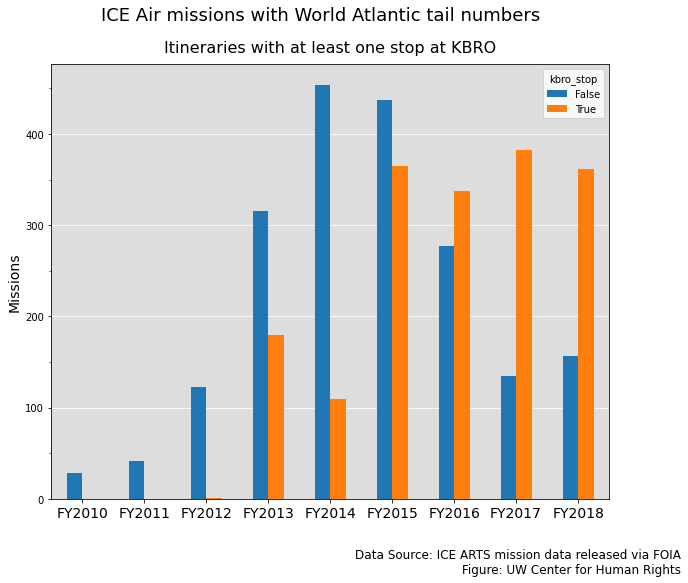

In [107]:
fig, ax = plt.subplots(figsize=(10,6))

data.plot(kind='bar', ax=ax, figsize=(10,8), color=cm.tab10(range(0,8,1)))

ax.set_facecolor('#DDDDDD')
ax.set_axisbelow(True)
ax.yaxis.grid(color='#FFFFFF')

ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_locator(MultipleLocator(100))
plt.xticks(rotation=0, fontsize=14)

plt.suptitle('ICE Air missions with World Atlantic tail numbers', fontsize=18)
plt.title('Itineraries with at least one stop at KBRO', fontsize=16, pad=12)
plt.ylabel('Missions', fontsize=14)
plt.xlabel('', fontsize=12)
txt='Data Source: ICE ARTS mission data released via FOIA\nFigure: UW Center for Human Rights'
plt.figtext(1, -.00, txt, wrap=True, horizontalalignment='right', fontsize=12)

plt.show();

In [11]:
df.loc[target_found, stop_cols].melt()['value'].value_counts().head(10)

KBRO    2765
KAEX     932
KMIA     692
MGGT     481
KSAT     334
KCSG     294
MHLM     286
KMDT     213
KGYY     213
KLRD     142
Name: value, dtype: int64

In [34]:
df.loc[target_found, 'MsnStart'].value_counts().head(5)

KBRO    1061
KMIA     340
KAEX     162
KSAT     135
KIWA      13
Name: MsnStart, dtype: int64

In [35]:
df.loc[target_found, 'MsnEnd'].value_counts().head(5)

KBRO    1064
KMIA     340
KAEX     153
KSAT     129
KIWA      19
Name: MsnEnd, dtype: int64

In [13]:
set(wal_tails).difference(set(df[target_found]['MsnTailNumber']))

{'N807TR'}

In [14]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

pgum = {'AirportName': 'Antonio B. Won Pat International Airport',
  'City': 'Barrigada and Tamuning',
  'Country': 'Guam',
  'LatitudeDecimalDegrees': 13.484,
  'LongitudeDecimalDegrees': 144.797,
  'State': np.nan}

msss = {'AirportName': 'Ilopango International Airport',
  'City': 'San Salvador',
  'Country': 'El Salvador',
  'LatitudeDecimalDegrees': 13.691667,
  'LongitudeDecimalDegrees': -89.125556,
  'State': np.nan}

airport_dict['PGUM'] = pgum
airport_dict['MSSS'] = msss

target_code = 'KBRO'
target_lon = airport_dict[target_code]['LongitudeDecimalDegrees']
target_lat = airport_dict[target_code]['LatitudeDecimalDegrees']
target_name = airport_dict[target_code]['AirportName']

In [15]:
missions_to_plot = df[target_found]
missions = missions_to_plot
missions.set_index('MissionDate', inplace=True)

/home/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


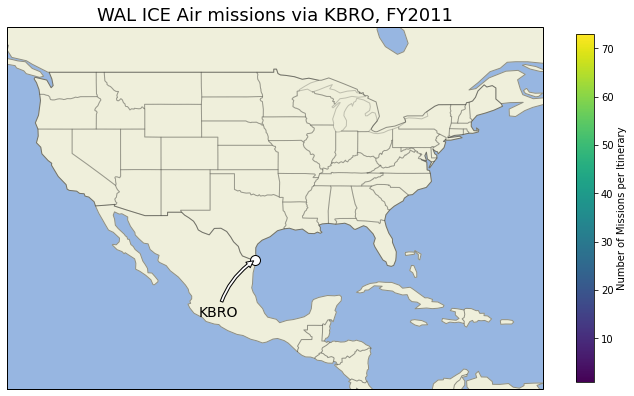

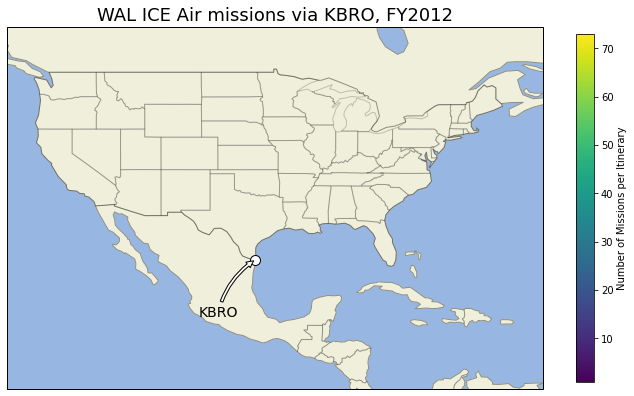

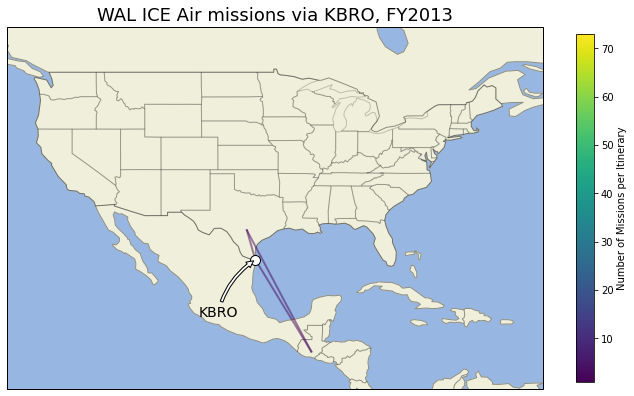

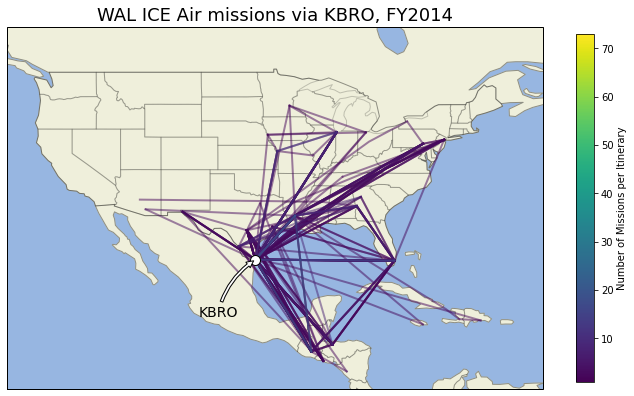

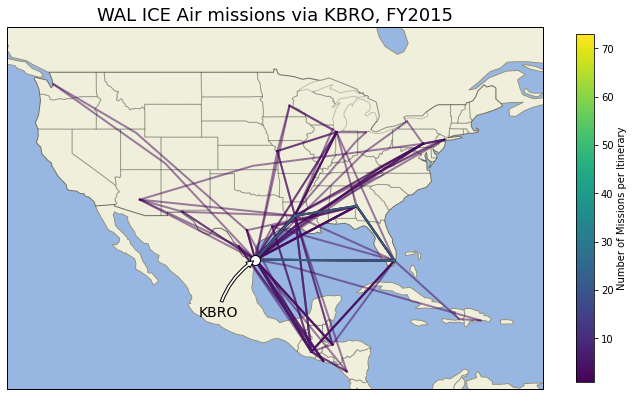

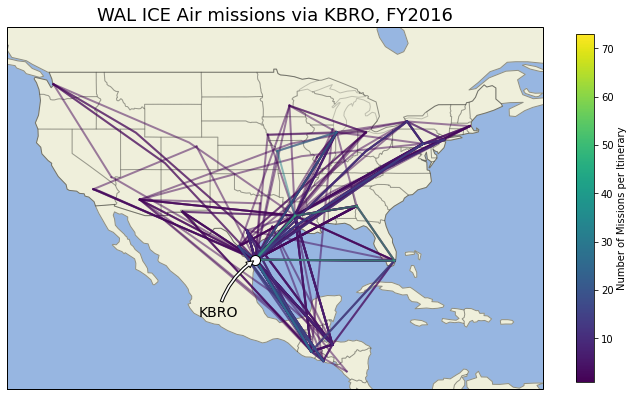

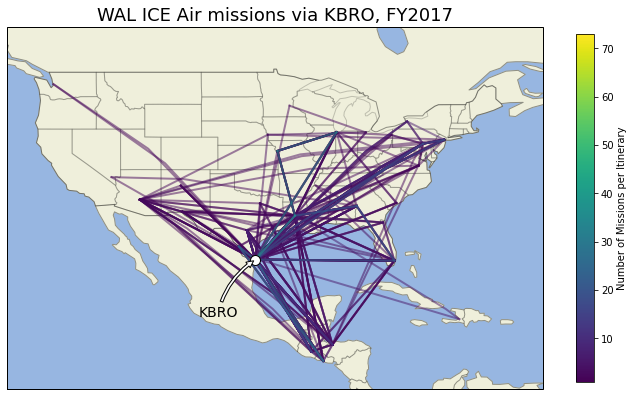

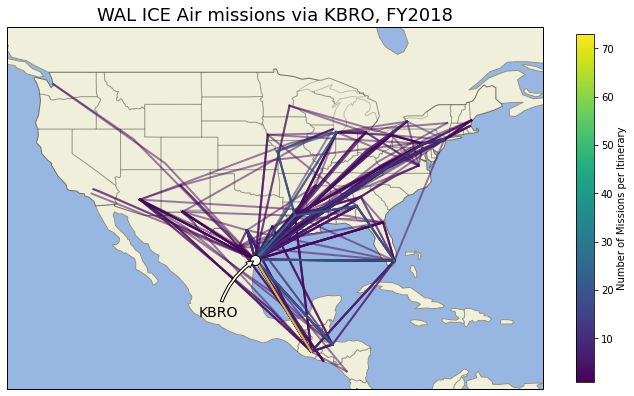

In [ ]:
missions.loc[:,stop_cols] = missions.loc[:, stop_cols].apply(lambda x: x.astype(object))
missions.loc[:,stop_cols] = missions.loc[:,stop_cols].fillna('-')

grouper = stop_cols.copy()
grouper.append(pd.Grouper(freq='AS-OCT'))

var = 'MissionID'
g = missions.groupby(grouper)[var].nunique().reset_index()
g.set_index('MissionDate',inplace=True)
g = g.replace('-', np.nan)

for year in range(2010, 2019):

# for year in [2018]:
    
    loop_count = g.loc[str(year)].sort_values(by=var, ascending=True)
    loop_count = loop_count.loc[str(year)].replace({'-': np.nan})
    loop_count = loop_count.loc[str(year)].sort_values(by=var, ascending=True)

    cm_lon=-109
    ax_proj = ccrs.PlateCarree(central_longitude=cm_lon)

    fig, ax = plt.subplots(
        1, 1, figsize=(12, 8),
        subplot_kw=dict(projection=ax_proj))
#     ax.stock_img()
    ax.set_global()
    ax.coastlines(alpha=.4)
    ax.add_feature(cfeature.BORDERS, alpha=.4)
    ax.add_feature(cfeature.STATES, alpha=.2)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)

    # Extent of continental US + Central America
    ax.set_extent([-128, -62, 10, 50])

    limit = len(loop_count)
    counter = 0

    color=cm.viridis(np.linspace(0,1,g[var].max()+1))

    for i, row in loop_count.iterrows():
        if counter > limit:
            break
        c=color[round(row[var])]
        itinerary = row[stop_cols]
        itinerary.dropna(inplace=True)
        len_stops = len(itinerary)
        for i in range(len_stops): # Add something to stop when reaching last airport
            try:
                point_1_code = itinerary[i]
                point_1_lon = airport_dict[point_1_code]['LongitudeDecimalDegrees']
                point_1_lat = airport_dict[point_1_code]['LatitudeDecimalDegrees']

                point_2_code = itinerary[i+1]
                point_2_lon = airport_dict[point_2_code]['LongitudeDecimalDegrees']
                point_2_lat = airport_dict[point_2_code]['LatitudeDecimalDegrees']

                if point_1_code == point_2_code:
                    break

                if point_1_lon < 0 and point_2_lon > 0 and point_2_lon > 45:
                    point_2_lon = point_2_lon - 360

                if point_1_lon > 0 and point_2_lon < 0 and point_2_lon > 45:
                    point_2_lon = point_2_lon + 360

                npts = 2
                x, y = np.linspace(point_1_lon, point_2_lon, npts), np.linspace(point_1_lat, point_2_lat, npts)

                plt.plot(x, y,
                color=c, linewidth=2, alpha=.5, transform=ccrs.Geodetic())
    

            except:
    #             print(f'Could not plot {point_1_code}->{point_2_code}')
                pass
        counter=counter + 1

    
    plt.plot(target_lon,
             target_lat,
             mfc='#FFFFFF',
             mec='#000000',
             markersize=10,
             marker='o',
             transform=ccrs.Geodetic())

    crs = ccrs.Geodetic()
    transform = crs._as_mpl_transform(ax)
    
    plt.annotate(target_code, (target_lon, target_lat),
                 xytext=(target_lon-7, target_lat-7),
                 fontsize=14,
                 arrowprops=dict(facecolor='white',
                            arrowstyle="simple",
                            connectionstyle="arc3,rad=-0.2",
                            alpha=1,
                                ),
                 annotation_clip=False,
                 xycoords=transform)
    
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin = g[var].min(), vmax=g[var].max()))
    sm._A = []
    
    label='Number of Missions per Itinerary'
    plt.colorbar(sm, shrink=.8, label=label)

    plt.title(label=f'WAL ICE Air missions via KBRO, FY{year+1}', size=18)
#     plt.savefig(f'../output/FY{year+1}-all-routes.png')
    plt.show()